## Generating vessels from a dataset

In this example we will discuss how to generate vessels from existing dataset in OpenTNSim and how to analyse specific locking output.

We take the following steps:

1. [Imports](#1-imports)
2. [Create vessel](#2-create-vessel)
3. [Create graph](#3-create-graph)
4. [Run simulation](#4-run-simulation)
5. [Inspect output](#5-inspect-output)

### 1. Imports
We start with importing the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os
import pathlib
import warnings

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim 
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot
import opentnsim.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


In [2]:
# Graph location
src_dir = pathlib.Path(opentnsim.__file__).parent.parent

# Graph location
location_graph = src_dir / "notebooks"
name_graph = location_graph / "Shape-Files" / "Rotterdam-Antwerpen-corridor" / "edges_2.shp"

# Vessel database
location_vessel_database = location_graph / "Vessels" / "richtlijnen-vaarwegen-2017.csv"

print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.1.2


### 2. Create vessel
The following section shows how to use the file `richtlijnen-vaarwegen-2017.csv` as a database for generating vessels. Inspect the file be opening it in excel to get a feel for how these datasets are structured and how you can use pandas to process this data.

In [3]:
#Load in the data
vessel_db = pd.read_csv(location_vessel_database)
vessel_db['v'] = 1
vessel_db['B'] = vessel_db['width']
vessel_db['type'] = vessel_db['vessel_type']
vessel_db['L'] = vessel_db['length']
vessel_db.head()




vessel_id vessel_type  width  length  \
0  12ad8a02-4aef-11e9-9940-b469212bff5b    CEMT - I   5.05    38.5   
1  17746aee-4aef-11e9-8ebf-b469212bff5b   CEMT - II   6.60    55.0   
2  1be5fb2e-4aef-11e9-9bfb-b469212bff5b  CEMT - III   8.20    85.0   
3  208a5aca-4aef-11e9-b7e9-b469212bff5b   CEMT - IV   9.50   105.0   
4  24f93100-4aef-11e9-8ff9-b469212bff5b   CEMT - Va  11.40   135.0   

   height_empty  height_full  draught_empty  draught_full  capacity  \
0          4.65         3.35            1.2           2.5       365   
1          5.80         4.60            1.4           2.6       615   
2          6.30         5.10            1.5           2.7      1250   
3          6.70         5.30            1.6           3.0      2040   
4          7.10         5.40            1.8           3.5      3735   

   installed_power  v      B        type      L  
0              175  1   5.05    CEMT - I   38.5  
1              250  1   6.60   CEMT - II   55.0  
2              435  1   8.20  CEMT - III   85.0  
3              690  1   9.50   CEMT - IV  105.0  
4             1425  1  11.40   CEMT - Va  135.0

We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _HasContainer_ - allows vessel to have cargo on board, 
* _HasResource_ - allows vessel to be requested 

These mixi-ins and the `vessels_db` dataframe are then combined in the vessel generator:

In [4]:
# Vessel type
Vessel = type('Vessel', 
              (
                  core.Identifiable, core.Movable, core.HasContainer, 
                  core.VesselProperties, core.HasResource, core.Routeable,
                  core.ExtraMetadata
              ), 
              {})

generator = model.VesselGenerator(Vessel, vessel_db)

### 3. Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

In [5]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)

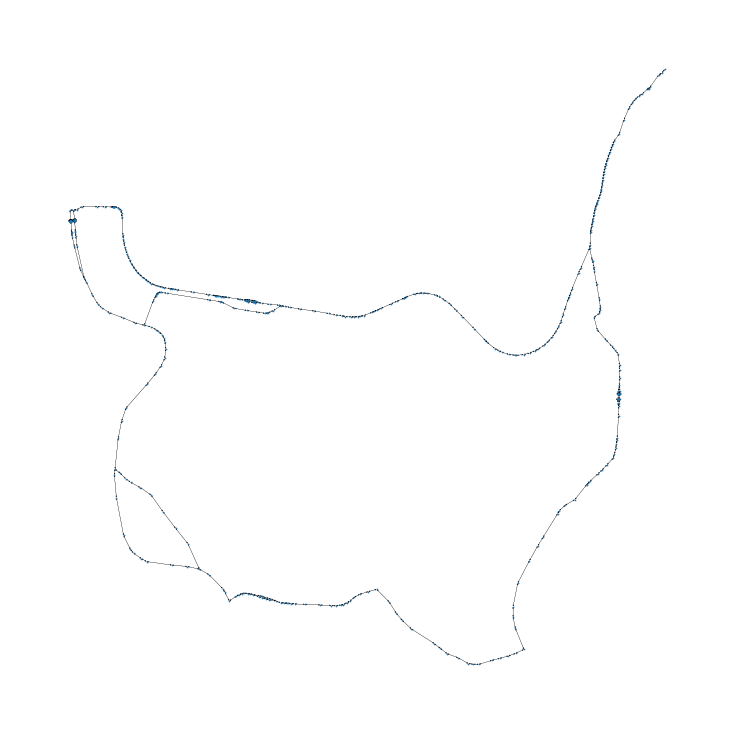

In [6]:
graph.create_graph_new_projection()
graph.plot()

### 4. Run simulation

In [7]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

# Add graph to environment
graph.add_resources(list(graph.graph.edges), np.ones(len(list(graph.graph.edges))), env)
env.FG = graph.graph

In [8]:
def start(env, vessel):
    while True:
        
        vessel.log_entry_v0("Start sailing", env.now, "0", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry_v0("Stop sailing", env.now, "0", vessel.geometry)

        if vessel.geometry == nx.get_node_attributes(env.FG, "geometry")[vessel.route[-1]]:
            break

In [9]:
vessels = []

# Add 10 vessels to the simulation
for i in range(10):
    random_1 = random.choice(list(graph.graph))
    random_2 = random.choice(list(graph.graph))
    path = nx.dijkstra_path(graph.graph, random_1, random_2)
    
    vessel = generator.generate(env, "Vessel " + str(i))
    vessel.route = path
    vessel.geometry = nx.get_node_attributes(env.FG, "geometry")[vessel.route[0]]
    vessels.append(vessel)
    
    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

In [10]:
# Run simulation
env.run()

### 5. Inspect output

In [11]:
df = pd.DataFrame.from_dict(vessel.log)
df.head()

Timestamp
0 2023-05-23 23:04:16.000000
1 2023-05-23 23:04:16.000000
2 2023-05-23 23:22:31.605423
3 2023-05-23 23:22:31.605423
4 2023-05-24 00:02:08.979450